In [1]:
import pickle
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from gala.coordinates import reflex_correct

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats


def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        #print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [4]:
def calc_distance(g, Ag):
    #Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [5]:
with open('gaiaRRlyrae.pkl', 'rb') as f:
    d = Table(pickle.load(f))


In [6]:
d.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'int_average_g',
 'int_average_g_error',
 'g_absorption',
 'g_absorption_error',
 'pmra_error',
 'pmdec_error',
 'pmra_pmdec_corr',
 'ebv',
 'peak_to_peak_g',
 'num_clean_epochs_g',
 'astrometric_excess_noise',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'g_transit_time',
 'g_transit_flux',
 'pf',
 'best_classification',
 'source_id']

In [7]:
Ag, Abp, Arp = getDust(d['int_average_g'], d['phot_bp_mean_mag'], d['phot_rp_mean_mag'], d['ebv'])

/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [8]:
bprp = (d['phot_bp_mean_mag'] - Abp) - (d['phot_rp_mean_mag'] - Arp)
distances = calc_distance(d['int_average_g'], Ag)
c = coord.SkyCoord(ra=d['ra']*u.deg, 
                   dec=d['dec']*u.deg, 
                  distance=distances*u.kpc)

cGal = c.transform_to(coord.Galactocentric)

In [9]:
import astropy

In [10]:
astropy.__version__

'3.0.2'

In [11]:
good = ~np.isnan(d['pmra']) & ~np.isnan(d['pmdec']) & (d['ebv'] < 5) & (bprp < 1) & (Ag < 5) & (d['best_classification'] == 'RRab') & (np.abs(cGal.z) > 1*u.kpc)

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [12]:
data = d[good]

In [13]:
Ag, Abp, Arp = getDust(data['int_average_g'], data['phot_bp_mean_mag'], data['phot_rp_mean_mag'], data['ebv'])

In [14]:
bprp = (data['phot_bp_mean_mag'] - Abp) - (data['phot_rp_mean_mag'] - Arp)

In [15]:
distances = calc_distance(data['int_average_g'], Ag)
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)

In [16]:
cGalactic = cCorrect.transform_to(coord.Galactic)

In [17]:
cGalTable = Table()
cGalTable['l'] = cGalactic.l
cGalTable['b'] = cGalactic.b
cGalTable['pm_l_cosb'] = cGalactic.pm_l_cosb
cGalTable['pm_b'] = cGalactic.pm_b
cGalTable['distance'] = distances




In [18]:
cGalTable.write('rrlyraeDynamics.txt', format='ascii')

In [19]:
vl = (cGalactic.pm_l_cosb*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vb = (cGalactic.pm_b*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())


In [20]:
cGal.set_representation_cls('cartesian')

In [21]:
c.shape

(79201,)

Text(0.5,1,'distances')

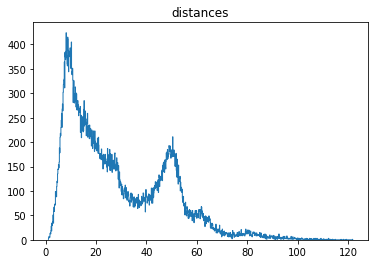

In [22]:
plt.hist(distances[~np.isnan(distances)], bins=1000, histtype='step')
plt.title('distances')

In [23]:
np.isnan(cGal.U).sum()
#for k in data.keys():
#    print(data[k][np.isnan(cGal.U)])
print(distances[np.isnan(cGal.U)], Ag[np.isnan(cGal.U)])

int_average_g
------------- ebv
---


In [24]:
locgalaxiesfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/NearbyGalaxies.dat'
locgaldata = Table.read(locgalaxiesfile, format='ascii')
gcfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/Harris-globclust.fits'
gcdata = Table.read(gcfile, format='fits')
locGalc = coord.SkyCoord(ra=locgaldata['RA'], dec=locgaldata['Dec'], unit=(u.hourangle, u.deg))
gcc     = coord.SkyCoord(ra=gcdata['ra'],     dec=gcdata['dec'], unit=(u.hourangle, u.deg))

locGalcGal = locGalc.transform_to(coord.Galactic)
gccGal = gcc.transform_to(coord.Galactic)

In [25]:
from sklearn.neighbors import KDTree as kdtree
import pandas as pd
import matplotlib as mpl

In [26]:
treedata = pd.DataFrame(data={'u':cGal.u/(1.*u.kpc), 
                              'v':cGal.v/(1.*u.kpc), 
                              'w':cGal.w/(1.*u.kpc),
                              'U':cGal.U/(10*u.km/u.s),
                              'V':cGal.V/(10*u.km/u.s), 
                              'W':cGal.W/(10*u.km/u.s)})

In [27]:
#treedataHigh = treedata.iloc[np.where(np.abs(cGalactic.b) >= 30.*u.deg)[0]]
#cGalacticHigh = cGalactic[np.abs(cGalactic.b) >= 30.*u.deg]

Text(0,0.5,'b')

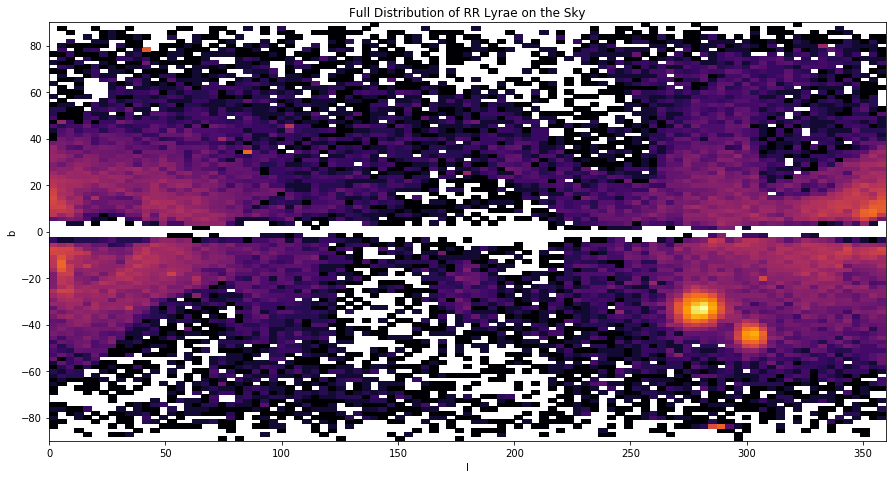

In [28]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'aspect': 'equal'})
nbins = 100
xbins = np.linspace(0, 360, nbins)
ybins = np.linspace(-90, 90, nbins)

H, xe, ye = np.histogram2d(cGalactic.l, cGalactic.b, bins=(xbins, ybins))
im = ax.pcolormesh(xe, ye, H.T,
      cmap='inferno', norm=mpl.colors.LogNorm())#, vmax=20) #, vmin=-100, vmax=100)
ax.set_title('Full Distribution of RR Lyrae on the Sky')
ax.set_xlabel('l')
ax.set_ylabel('b')

In [29]:
tree = kdtree(treedata)

In [30]:
radius = 3.0


In [31]:
(ind, dist) = tree.query_radius(treedata, radius, count_only = False, return_distance = True)

In [66]:
maxMembers= 2
minMembers = 2
clumps = []
for i in ind:
    if (len(i)>=minMembers) & (len(i)<=maxMembers): 
        clumps.append(i)
print(len(clumps))

13377


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


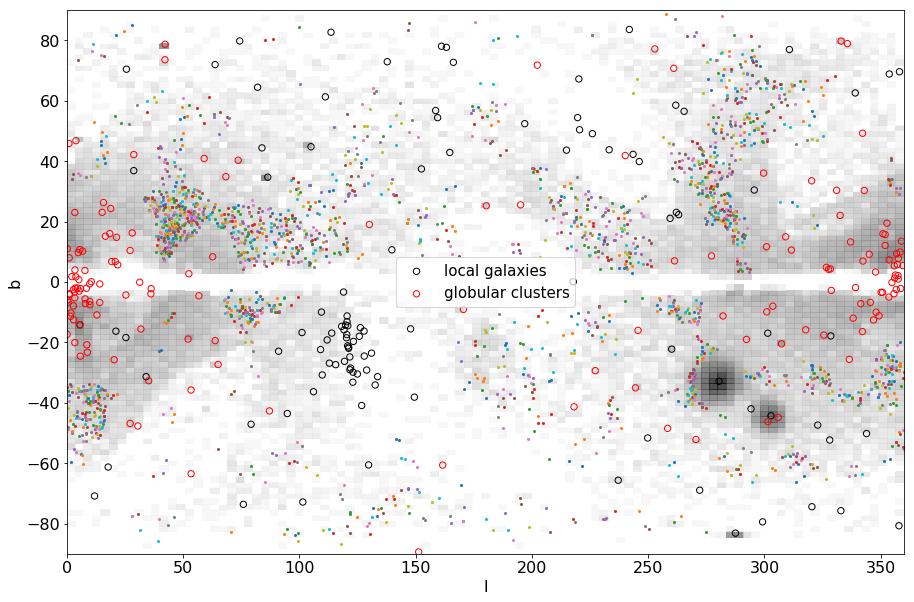

In [67]:
#clumpTable = Table()
clumpTable = pd.DataFrame(columns = ('indices', 'ra', 'dec', 'pmra', 'pmdec', 'distance', 'width', 'angularSizeR', 'l', 'b'))
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
ti = 0
distToKnown = 10 #deg
widthOfClump = 1 # kpc
maxSameAsBefore = 1
for j in range(len(clumps)):
    #check that it's small in physical space
    small = treedata.iloc[clumps[j]]
    width = np.max((small.u - np.mean(small.u))**2 + (small.v - np.mean(small.v))**2 + (small.w - np.mean(small.w))**2) #kpc
    if width < widthOfClump :
        #check that it isn't something already known 
        co = cGalactic[clumps[j]]
        dist_known = np.zeros(len(co) + len(co))
        for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
            dist_known[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
            dist_known[ii + len(co)] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
        #print(np.min(dist_known))
        if np.min(dist_known) > distToKnown: 
            #check that you haven't already plotted it 
            samesies = 0
            for k in range(j):
                same = np.in1d(clumps[j], clumps[k])
                #print(same, np.sum(same), j, k)
                samesies += np.sum(same)
            if (samesies < maxSameAsBefore+1):
                #color = next(colors)
                dnow= data[clumps[j]]
                clumpTable.loc[ti] = [clumps[j], dnow['ra'], dnow['dec'], dnow['pmra'], dnow['pmdec'], 
                                      distances[clumps[j]], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi), 
                                     np.median(cGalactic.l[clumps[j]]), np.median(cGalactic.b[clumps[j]])]
                ti += 1
                #print(samesies, clumps[j], dnow['ra'][0], dnow['dec'][0], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi))
                axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*2)#, c=color)
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
axSky.legend(fontsize=15)
#plt.close(fig)

In [49]:
print(np.sqrt(np.var(clumpTable.iloc[0]['pmra']))*4, np.sqrt(np.var(clumpTable.iloc[0]['pmdec']))*4)

0.43601420197892393 0.5457976043613754


In [57]:
from os import path
import sqlutilpy as sqlutil
def queryDatabase(query, columns, post_query, cache_file='db.pickle', queryPro=None):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        if queryPro is not None:
            res = sqlutil.get(queryPro,
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)
        else:
            res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [51]:
dataCMD = Table.read('/Users/landerson/Downloads/MIST_iso_5b18346c0ece6.iso.cmd', format='ascii.commented_header', header_start=12)

In [52]:
dataCMD.keys()

['EEP',
 'isochrone_age_yr',
 'initial_mass',
 'star_mass',
 'log_Teff',
 'log_g',
 'log_L',
 '[Fe/H]_init',
 '[Fe/H]',
 'Bessell_U',
 'Bessell_B',
 'Bessell_V',
 'Bessell_R',
 'Bessell_I',
 '2MASS_J',
 '2MASS_H',
 '2MASS_Ks',
 'Kepler_Kp',
 'Kepler_D51',
 'Hipparcos_Hp',
 'Tycho_B',
 'Tycho_V',
 'Gaia_G_DR2Rev',
 'Gaia_BP_DR2Rev',
 'Gaia_RP_DR2Rev',
 'TESS',
 'phase']

In [53]:
dataCMD['phase'].max()

6.0

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


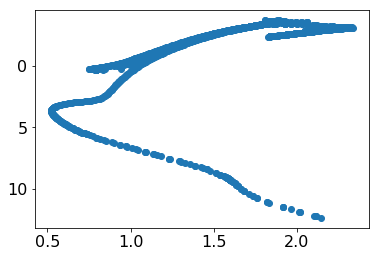

In [54]:
good = (dataCMD['phase'] <6) & (dataCMD['phase'] > -1)
plt.scatter(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good])
plt.gca().invert_yaxis()

In [256]:
clumpTable

,indices,ra,dec,pmra,pmdec,distance,width,angularSizeR,l,b
0,"[2306, 766, 2621]","[91.2060263283528, 88.6964313855679, 91.939428...","[66.007951437278, 67.2498283345658, 67.6664288...","[1.33566669401714, 1.30912335793593, 1.0923090...","[-2.26968156538498, -1.9407990065658, -2.05366...","[21.01929638309657, 21.796064501291198, 20.845...",0.420907,1.1569040305640181,146d28m56.2742s,20d05m23.0245s
1,"[1122, 13026, 13009]","[130.516584835695, 119.022116271472, 125.46392...","[7.23613678036334, 4.25772360434296, 3.3986855...","[0.786180248493232, 0.669332014622964, 1.33003...","[-7.02282595581775, -7.32907953679718, -8.2307...","[7.646974788603073, 7.384083817649416, 6.60213...",0.789203,6.849002149373664,219d17m14.9376s,21d37m26.1221s
2,"[3528, 3535, 3411, 3532]","[243.777738476571, 244.194900186389, 245.12420...","[28.9947103026651, 30.2414770805192, 27.054410...","[-1.58778699225865, -1.62676954276691, -1.5509...","[-1.14000894328257, -1.36002859954532, -1.2701...","[23.772184861614928, 25.336127171162584, 24.98...",0.883976,2.130561275605705,48d04m55.2046s,45d18m28.6557s
3,"[3260, 4051, 4064]","[228.519159828708, 231.589961310492, 232.41992...","[33.0808711416074, 39.0244447964034, 42.838396...","[-4.74492662760153, -4.39457180415358, -4.3522...","[-2.11157966951322, -1.52128380793762, -1.9448...","[8.355007031195692, 9.282053363185966, 9.02702...",0.991886,6.802015725649204,63d13m57.4509s,55d44m19.6531s
4,"[7480, 7571, 7544]","[316.096907107042, 313.032905133292, 310.13228...","[30.4498415315271, 31.8075101107866, 29.085416...","[-0.408743896105379, -0.620230566021582, -0.48...","[-1.03123265902066, -1.1169113924253, -1.08607...","[18.84729573897388, 17.815916234132246, 18.742...",0.969416,3.1176315106058747,75d01m57.6539s,-8d02m13.3355s
5,"[9277, 9291, 9908]","[299.614890521772, 298.65273147052, 292.941263...","[47.1411718946782, 47.7998039325747, 51.425378...","[-0.0532699612544289, -0.119711851718747, -0.0...","[0.711237998962345, 0.58315281546612, 1.041170...","[13.222947214521719, 13.233405324118019, 13.68...",0.872222,3.779385644350698,81d53m52.6009s,10d05m01.081s
6,"[9279, 9918, 9824]","[298.976144502952, 297.356168377228, 290.07867...","[47.5111469014122, 51.665026233196, 47.1301220...","[-2.71287286919724, -2.79452409483281, -2.3542...","[-3.86524665099656, -3.63625171225078, -4.2840...","[6.030971694953683, 5.959665592106144, 5.64916...",0.212712,2.1573935275398126,81d45m10.5785s,12d40m44.3297s
7,"[9654, 9662, 9736]","[275.926029236977, 278.269539634672, 276.51958...","[41.5416629952559, 43.2321796129083, 47.923005...","[-2.41785831540402, -2.40531668871705, -2.1551...","[-1.17762325296417, -1.09034378106086, -1.4617...","[14.42632747095859, 14.102367331859655, 14.123...",0.848699,3.4481353178329925,71d41m19.4774s,22d30m27.2293s
8,"[9965, 9917, 9957]","[288.744484579432, 293.006101275874, 291.55034...","[56.2922562910503, 53.372483417766, 54.9091280...","[-0.414959385104109, -0.392552831363447, -0.53...","[0.0527695448865637, 0.254434143748554, 0.1183...","[21.3423713379682, 20.429848209929876, 20.3180...",0.932260,2.628919716042409,86d25m36.4101s,17d12m18.8899s
9,"[10382, 10068, 10394]","[293.609614369835, 284.813027548551, 289.10048...","[59.6302348060852, 61.2510408738237, 60.523914...","[-0.843082387455514, -1.2664702516083, -1.5586...","[1.0303199974995, 0.827546163366168, 0.8956967...","[17.893298311078127, 17.424669790074635, 16.86...",0.770820,2.6182356400848774,91d27m46.5252s,20d26m52.168s


In [63]:
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
goodcmd = (dataCMD['phase'] <6) & (dataCMD['phase'] > -1)

cmd_bprp = dataCMD['Gaia_BP_DR2Rev'][goodcmd] - dataCMD['Gaia_RP_DR2Rev'][goodcmd]
cmd_MG = dataCMD['Gaia_G_DR2Rev'][goodcmd]
index_order = np.argsort(clumpTable['angularSizeR'].values)
#print(index_order[1])
minr = np.min(clumpTable['angularSizeR'])
print('distance, pmra, pmdec, pmrasig, pmdecsig, ra, dec, angular distance')
for ii, i in enumerate(range(len(index_order))):
    i = index_order[i]
    nstars = len(clumpTable.loc[i]['ra'])
    ra = clumpTable.loc[i]['ra'][0]
    dec = clumpTable.loc[i]['dec'][0]
    pmra = clumpTable.loc[i]['pmra'][0]
    pmdec = clumpTable.loc[i]['pmdec'][0]
    angular_distance = clumpTable.loc[i]['angularSizeR']
    distance = clumpTable.loc[i]['distance'][0]
    #print(ra, dec, pmra, pmdec, angular_distance, distance)

    pm2Max = pmra**2 + pmdec**2
    pmramed = np.median(clumpTable.loc[i]['pmra'])
    pmdecmed = np.median(clumpTable.loc[i]['pmdec'])
    pmrasig = np.sqrt(np.var(clumpTable.iloc[i]['pmra']))
    pmdecsig = np.sqrt(np.var(clumpTable.iloc[0]['pmdec']))
    print(distance, pmramed, pmdecmed, pmrasig, pmdecsig, angular_distance)

    
    queryPro = """WITH x AS (SELECT  * FROM gaia_dr2.gaia_source AS gs WHERE q3c_radial_query(gs.ra, gs.dec, {0}, {1}, {2}))
    SELECT x.ra, x.dec, x.pmra, x.pmdec, phot_g_mean_mag, ebv, phot_bp_mean_mag, phot_rp_mean_mag
        FROM x
            WHERE parallax < {3} AND abs(pmra - {4:0.6f}) < {5:0.6f}*4 AND abs(pmdec - {6:0.6f}) < {7:0.6f}*4;""".format(ra, dec, angular_distance, 
                                                                                               10./distance, pmramed, pmrasig,
                                                                                              pmdecmed, pmdecsig)
    

    #columns = ['parallax', 'int_average_g', 'ebv', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
    #query = """select {0} from gaia_dr2.gaia_source as gs, gaia_DR2.vari_rrlyrae as rr {1}"""
    #cuts = "WHERE ".format(ra, dec, angular_distance)
    query = ""
    columns = ""
    cuts = ""
    res = queryDatabase(query, columns, cuts, cache_file='rrlyrae_pairs_{0}.pkl'.format(i), queryPro=queryPro)


    dnow = Table(res)
    Ag, Abp, Arp = getDust(dnow['phot_g_mean_mag'], dnow['phot_bp_mean_mag'], dnow['phot_rp_mean_mag'], dnow['ebv'])
    bprp = (dnow['phot_bp_mean_mag'] - Abp) - (dnow['phot_rp_mean_mag'] - Arp)

    MG = dnow['phot_g_mean_mag'] - Ag - 5.*np.log10(distance*1e3/10)


    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    if len(dnow) > 2000:
        xbins = np.linspace(0, 2, 50)
        ybins = np.linspace(-6, 10, 200)
        HH, xx, yy = np.histogram2d(bprp, MG, bins=(xbins, ybins))
        im = ax[0].pcolormesh(xx, yy, HH.T,
          cmap='inferno', norm=mpl.colors.LogNorm())
        ybins = np.linspace(10, 20, 200)
        HH, xx, yy = np.histogram2d(bprp, dnow['phot_g_mean_mag'] - Ag, bins=(xbins, ybins))
        im = ax[1].pcolormesh(xx, yy, HH.T,
          cmap='inferno', norm=mpl.colors.LogNorm())
        ax[1].invert_yaxis()
        ax[1].set_ylim(20, 10)
    else:
        ax[0].scatter(bprp, MG, s=1)
        ax[1].scatter(bprp, dnow['phot_g_mean_mag'] - Ag, s=1)
        for axis in [ax[0], ax[1]]:
            axis.set_xlim(0, 2)
        ax[0].set_ylim(10, -6)
        ax[1].set_ylim(20, 10)
    ax[0].scatter(cmd_bprp, cmd_MG, s=3, alpha=0.1)
    ax[1].scatter(cmd_bprp, cmd_MG + 5.*np.log10(distance*1e3/10), s=3, alpha=0.1)
    
    ax[0].set_xlim(0, 2)
    ax[0].set_ylim(10, -6)
    ax[0].set_xlabel('bp - rp')
    ax[0].set_ylabel('M_G')
    ax[0].set_title('{0:0.2f} kpc'.format(distance))
    ax[1].set_xlabel('bp - rp')
    ax[1].set_ylabel('G')
    ax[1].set_title('{0} RRlyrae'.format(nstars))

    ax[2].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
    ax[2].scatter(clumpTable.loc[i]['l'], clumpTable.loc[i]['b'], s=100)
    ax[2].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies', alpha=0.5, zorder=np.inf)
    ax[2].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters', alpha=0.5, zorder=np.inf)
    ax[2].set_xlabel('l')
    ax[2].set_ylabel('b')
    ax[2].set_xlim(0, 360)
    ax[2].set_ylim(-90, 90)
    vtannow = np.sqrt(pmra**2 + pmdec**2)*4.*distance
    ax[2].set_title('{0:0.2f} km/s'.format(vtannow))
    plt.tight_layout()
    fig.savefig('cmd_rrlyrae_{0:02d}.png'.format(ii))
    plt.close(fig)

    #plt.gca().invert_yaxis()

distance, pmra, pmdec, pmrasig, pmdecsig, ra, dec, angular distance
21.01929638309657 1.30912335793593 -2.0536634245061 0.10900355049473098 0.13644940109034384 1.1569040305640181


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


16.354249924642943 -1.06912416945853 -1.80924829742085 0.17456296957812747 0.13644940109034384 1.450502872281285
19.95402219406398 -1.09960513130722 -1.42661414089974 0.03265925804499165 0.13644940109034384 1.791362622095845
15.182211637254973 0.807866849877667 -1.72638337034906 0.2237132463831778 0.13644940109034384 1.913999597806192
25.501123471777703 -1.24074181717145 -2.90434705837091 0.08161039004133565 0.13644940109034384 1.9613698317310355
22.070435955634817 -0.93653277365625 -1.76528786893236 0.08304969921099735 0.13644940109034384 1.9933186752228358
23.772184861614928 -1.569380559515485 -1.2517431059798199 0.09546594363150934 0.13644940109034384 2.130561275605705
6.030971694953683 -2.71287286919724 -3.86524665099656 0.19123322784711147 0.13644940109034384 2.1573935275398126


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


11.75789068120294 1.60620244888646 -2.8375462249155 0.21338763632176197 0.13644940109034384 2.1846490331237653


/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


16.36022429275914 -2.62802349651953 -2.04293158915739 0.1453890705261413 0.13644940109034384 2.20169158462894
23.181488633231247 -1.49260641625915 -1.48447962378732 0.0824011028392774 0.13644940109034384 2.313476889148474
17.893298311078127 -1.2664702516083 0.895696797749317 0.293746727468593 0.13644940109034384 2.6182356400848774
17.93428853183063 -1.65068901852023 -1.44123226985698 0.08398320954913203 0.13644940109034384 2.6223040579483694
21.3423713379682 -0.414959385104109 0.118301462187174 0.062034760992395396 0.13644940109034384 2.628919716042409
18.84729573897388 -0.483836634392663 -1.08607334816645 0.08753972779443996 0.13644940109034384 3.1176315106058747
16.584269464412532 -2.34157117372863 -1.54385376459661 0.18108142014106787 0.13644940109034384 3.2317016505493097
7.821550847131058 -3.9188552958197 -2.5983051243649 0.14623640083022924 0.13644940109034384 3.282815619080858
16.028830487472472 -1.32947269493757 -2.61272684640821 0.04184263821079354 0.13644940109034384 3.347707

In [60]:
blah

NameError: name 'blah' is not defined

In [188]:
small = cGal[clumps[j]]
print(np.max((small.u.value - np.mean(small.u.value))**2 + (small.v.value - np.mean(small.v.value))**2 + (small.w.value - np.mean(small.w.value))**2))

1.731722790771223


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[7402 7360 7414 7062 7351 7586 7434 7405 7662 7561]
[9593 9745 9850 9060 9563 9541 9538 9560 9069 9544]
[9971 9848 9825 9759 9223 9961 9297 9912 9216 9250]
[22758 22885 22880 22245 22319 22519 22902 22327 22335 22842]
[54988 57700 53728 55066 57893 57696 57881 57689 55108 57658]
[55875 56120 56212 56254 55675 55851 56136 56112 56144 56192]


(-90, 90)

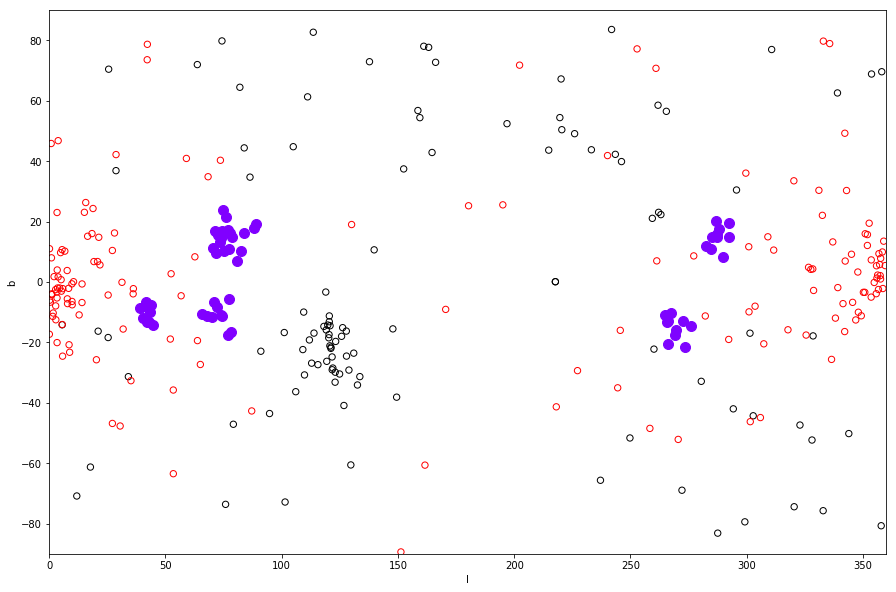

In [33]:
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
for j, ci in enumerate(clumps):
    samesies = 0
    for k in range(j):
        same = np.in1d(clumps[j], clumps[k])
        samesies += np.sum(same)
    #if clumps[j] != clumps[j-1]
    if samesies < 1:
        small = treedata.iloc[clumps[j]]
        co = cGalactic[clumps[j]]
        vll = vl[clumps[j]]
        vbb = vb[clumps[j]]
        dist_known_gal = np.zeros(len(co))
        dist_known_gcc = np.zeros(len(co))
        for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
            dist_known_gal[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
            dist_known_gcc[ii] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
        dist_known = np.concatenate((dist_known_gal, dist_known_gcc))
        if np.min(dist_known) < 5: 
            continue
        fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
        xx = [co.l, co.b, co.l]
        yy = [co.b, co.distance, co.distance]
        vxx = [vll, vbb, vll]
        vyy = [vbb, np.zeros(len(vbb)), np.zeros(len(vll))]
        #xx = [small.u, small.v, small.w]
        #yy = [small.v, small.w, small.u]
        #vxx = [small.U, small.V, small.W]
        #vyy = [small.V, small.W, small.U]
        lxx = ['l', 'b', 'l']
        lyy = ['b', 'd', 'd']
        color = next(colors)
        for i, (x, y, vx, vy, lx, ly) in enumerate(zip(xx, yy, vxx, vyy, lxx, lyy)):
            ax[i].quiver(x, y, vx, vy, color=color)
            ax[i].set_xlabel(lx)
            ax[i].set_ylabel(ly)
            #axAll.quiver(x, y, vx, vy)
        ax[3].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
        ax[3].scatter(co.l, co.b, s=40, c=color)
        ax[3].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
        ax[3].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
        ax[3].set_xlabel('l')
        ax[3].set_ylabel('b')
        ax[3].set_xlim(0, 360)
        ax[3].set_ylim(-90, 90)
        #ax[3].legend(fontsize=15)
        plt.tight_layout()
        fig.savefig('rrLyrae_kdtree_{0:03d}.png'.format(j))
        plt.close(fig)
        axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*10, c=color)
        print(clumps[j])
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
#plt.close(fig)